# Messung von Q2 ohne QFP1 Annealing

In [1]:
%matplotlib inline
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import cmath
from scipy.special import gamma, factorial
from qiskit.quantum_info.states.utils import (_funm_svd)
import multiprocessing as mp

In [2]:
# Parameter

N = 21
xi1 = .5 # 10^10 Hz
xi2= .5
m1 = 1/(4 * xi1**2)
m2 = 1/(4 * xi2**2)
omega_qfp1 = 2 * xi1
omega_qfp2 = 2 * xi2

omega_r = 1.2 * omega_qfp2
delta = omega_r-omega_qfp2

toq1 = .09; toqfp1 = 1/toq1
toq2 = .12; toqfp2 = 1/toq2

eps1 = toq1*omega_qfp1
eps2 = toq2*omega_qfp2

eta1 = m1*omega_qfp1
eta2 = m2*omega_qfp2

In [3]:
def parameter(rde2, rdg):
    
    rde1 = rde2
    
    rde2_eff = rde2 * np.exp(-eta1)
    
    Del1 = eps1 * rde1
    Del2 = eps2 * rde2
    
    Del2_eff = eps2 * rde2_eff
    
    omega_q1 = eps1 * cmath.sqrt(1+rde1**2)
    omega_q2 = eps2 * cmath.sqrt(1+rde2**2)
    
    J = (omega_q2-omega_q1)/20
    
    omega_eff2 = toqfp2 * eps2 * cmath.sqrt(1+rde2_eff**2)
    
    delta_eff2 = omega_r - omega_eff2
    theta1 = np.arctan(rde1)
    theta_eff2 = np.arctan(rde2_eff)
    
    g = delta/rdg
    g2 = g*np.sin(theta_eff2)
    
    chi2 = g2**2/delta_eff2
    
    return (J, g2, chi2, theta1, theta_eff2, delta_eff2)

In [4]:
z1 = tensor(sigmaz(), qeye(2), identity(N))
z2 = tensor(qeye(2), sigmaz(), identity(N))
x1 = tensor(sigmax(), qeye(2), identity(N))
x2 = tensor(qeye(2), sigmax(), identity(N))
zz = tensor(sigmaz(), sigmaz(), identity(N))
xz = tensor(sigmax(), sigmaz(), identity(N))
zx = tensor(sigmaz(), sigmax(), identity(N))
xx = tensor(sigmax(), sigmax(), identity(N))
yy = tensor(sigmay(), sigmay(), identity(N))
a = tensor(qeye(2), qeye(2), destroy(N))

In [5]:
def Hamilton(rde2, rdg, alpha):
    
    (J, g2, chi2, theta1, theta_eff2, delta_eff2) = parameter(rde2, rdg)
    
    J *=toqfp2
    
    #HQ1 = -(eps1*z1 + Del1*x1 )/2
    #He2 = -(epsqfp2*z2 + Delqfp2_eff*x2 )/2
    #Hint = g*z2*(a.dag()+a) + omega_r*a.dag()*a + J*z1*z2
    
    #################################################
    # Q2 Eigenbasis
    #################################################
    
    delta2_n = ((delta_eff2  + chi2) + 2*chi2*a.dag()*a)
    delta2_0 = delta_eff2 + chi2
    
    #omega2_n = ((omegaqfp2_eff + chi) + 2*chi*a.dag()*a)
    #omega2_0 = omegaqfp2_eff + chi
    
    J2zz = J * np.cos(theta_eff2)
    J2zx = J* np.sin(theta_eff2)
    
    Hf = - delta2_n/2 *(np.cos(theta_eff2)*z2+np.sin(theta_eff2)*x2) + J*zz # Fluss Basis
    
    H2b = - delta2_n/2 *z2 + J2zz*zz- J2zx*zx #Q2 Energieeigenbasis
    
    omega20_pm = lambda S: cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    cos20_pm = lambda S: (delta2_0/2 + np.sign(S)*J2zz)/ cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    sin20_pm = lambda S: (-np.sign(S)*J2zx)/ cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    
    H2d = -1/2 * ((delta2_n/2 - J2zz)*cos20_pm(-1)+J2zx*sin20_pm(-1)) *(z2+zz)\
    -1/2 * (-(delta2_n/2 - J2zz)*sin20_pm(-1)+J2zx*cos20_pm(-1))*(x2+zx)\
    -1/2 * ((delta2_n/2 + J2zz)*cos20_pm(1)-J2zx*sin20_pm(1))*(z2-zz)\
    -1/2 * (-(delta2_n/2 - J2zz)*sin20_pm(1)-J2zx*cos20_pm(1))*(x2-zx)# dressed Basis
    
    return (chi2, Hf, H2b, H2d)

In [6]:
def odd (n):
    if (n % 2) == 0:
        return 0
    else:
        return 1

In [7]:
def fid_norm(opr1, opr2):
    
    s1sq = _funm_svd(opr1, np.sqrt)
    s2sq = _funm_svd(opr2, np.sqrt)
    fid = np.linalg.norm(s1sq.dot(s2sq), ord='nuc')**2
    
    return float(np.real(fid))

In [8]:
zus00 = ket("00")
zus01 = ket("01")
zus10 = ket("10")
zus11 = ket("11")

#psi0q1 = (basis(2, 0) + basis(2, 1)).unit()
#psi0q2 = (basis(2, 0) + basis(2, 1)).unit()
psi0_q = (zus00+zus01+zus10+zus11).unit()

rho0_q = ket2dm(psi0_q)
rho0_q1 = psi0_q.ptrace(0)
rho0_q2 = psi0_q.ptrace(1)

In [9]:
def ideal_pm(S):
    
    if np.sign(S) == 1:
            
        Mid = (zus00 * zus00.dag()+zus10 * zus10.dag()) * rho0_q * (zus00 * zus00.dag()+zus10 * zus10.dag())
        
    elif np.sign(S) == -1:
        Mid = (zus01 * zus01.dag()+zus11 * zus11.dag()) * rho0_q * (zus01 * zus01.dag()+zus11 * zus11.dag())
    
    return Mid

In [10]:
def ideal():
      
    ideal_p = ideal_pm(1)
    ideal_m = ideal_pm(-1)
    
    Fid = (ideal_p+ideal_m).ptrace(1)
    
    return Fid

In [11]:
def Mess_pm(H, t, alpha, S):
    
    nsteps = 1000
    while not 'U' in locals():
        try:
            U = propagator(H, t, options = Options(num_cpus=5, rtol = 1e-08, nsteps=nsteps))
        except:
            nsteps *= 10
            if nsteps>10000000:
                raise SystemExit('nsteps too large')
    
    #U = propagator(H, t, options = Options(atol=1e-10, rtol = 1e-08, nsteps=1000000))
    
    F = 0
    
    for l in range(0, N):
        for k in range(0, N):
            fcl = tensor(qeye(2), qeye(2), fock(N, l))
            fck = tensor(qeye(2), qeye(2), fock(N, k))
 
            if l == k:
        
                e = np.exp(-alpha**2)* alpha **(2*l)/(2 * factorial(l))\
                * (fcl.dag()* U * fcl) * rho0_q * (fcl.dag() * U * fcl)
                    
            else:
                e = (-np.sign(S) * np.exp(-alpha**2)) * (1j/np.pi) * alpha **(l+k) \
                * gamma((l+k)/2 + 1)* odd(k-l)/(factorial(k) * factorial(l)*(k-l)) \
                * (fcl.dag() * U * fcl) * rho0_q * (fck.dag() * U * fck)
                     
            F += e
    
    return F

In [12]:
def Mess(H, t, alpha):
    
    M_p = Mess_pm(H, t, alpha, 1)
    M_m = Mess_pm(H, t, alpha, -1)
    
    M = (M_p+M_m).ptrace(1)
    
    return M

In [13]:
def fid(H, t, alpha):
    
    M = Mess(H, t, alpha)
    M_id = ideal()
    
    F = fid_norm(M, M_id)
    
    return F

In [14]:
def main(rde2, rdg, alpha, rtc):
    
    oper = Hamilton(rde2, rdg, alpha)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(1, len(oper))]

    return F

In [15]:
rdg_list = np.linspace(8, 15, 25)

In [16]:
(rde2, alpha, rtc) =(.5, 2, np.pi/2)

In [17]:
%time F_rdg = [main(rde2, rdg, alpha, rtc) for rdg in rdg_list]

C:\Users\yanju\.conda\envs\qutip-env\lib\site-packages\scipy\integrate\_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Wall time: 1h 37min 51s


In [18]:
chi_list = []
for rdg in rdg_list:
    C = Hamilton(rde2, rdg, alpha)
    chi_list.append(C[0]/omega_qfp2)

C:\Users\yanju\.conda\envs\qutip-env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


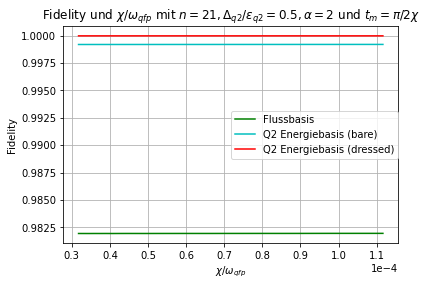

In [35]:
fig, ax = plt.subplots()
ax.plot(chi_list, [f[0] for f in F_rdg], 'g', label='Flussbasis')
#ax.plot(rdg_list, [f[0] for f in F_rdgzz], 'm', label='Q1 und Q2 Eigenbasis')

ax.plot(chi_list, [f[1] for f in F_rdg], 'c', label='Q2 Energiebasis (bare)')
ax.plot(chi_list, [f[2] for f in F_rdg], 'r', label='Q2 Energiebasis (dressed)')

ax.set_xlabel(r"$\chi/\omega_{qfp}$")
#ax.set_xlim(.0001, .0004)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_ylabel('Fidelity')
ax.set_title(r'Fidelity und $\chi/\omega_{qfp}$ mit $n =%s, \Delta_{q2}/\epsilon_{q2}=%s, \alpha=%s$ und $t_m = \pi/2\chi$'\
             %(N, rde2, alpha))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, borderaxespad=0.)
text = ax.text(1.02,1.05, " ", transform=ax.transAxes)
ax.grid()
plt.savefig('o_chi_fq2_5.png', bbox_extra_artists=(lgd, text), bbox_inches='tight')

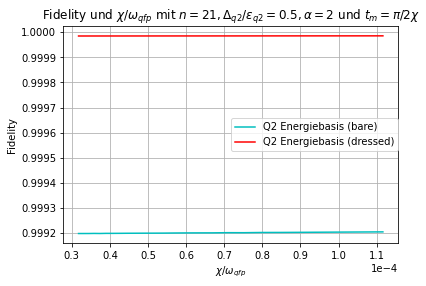

In [36]:
fig, ax = plt.subplots()
#ax.plot(chi_list, [f[0] for f in F_rdg], 'g', label='Flussbasis')
#ax.plot(rdg_list, [f[0] for f in F_rdgzz], 'm', label='Q1 und Q2 Eigenbasis')

ax.plot(chi_list, [f[1] for f in F_rdg], 'c', label='Q2 Energiebasis (bare)')
ax.plot(chi_list, [f[2] for f in F_rdg], 'r', label='Q2 Energiebasis (dressed)')

ax.set_xlabel(r"$\chi/\omega_{qfp}$")
#ax.set_xlim(.0001, .0004)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_ylabel('Fidelity')
ax.set_title(r'Fidelity und $\chi/\omega_{qfp}$ mit $n =%s, \Delta_{q2}/\epsilon_{q2}=%s, \alpha=%s$ und $t_m =\pi/2\chi$'\
             %(N, rde2, alpha))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, borderaxespad=0.)
text = ax.text(1.02,1.05, " ", transform=ax.transAxes)
ax.grid()
plt.savefig('o_chi_q2_5.png', bbox_extra_artists=(lgd, text), bbox_inches='tight')

In [8]:
rdg_list = np.linspace(5, 50, 100)

In [9]:
(rde2, alpha, rtc) =(.3, 2, np.pi/2)

In [10]:
chi_list = []
for rdg in rdg_list:
    C = Hamilton(rde2, rdg, alpha)
    chi_list.append(C[0]/omega_qfp2)

C:\Users\yanju\.conda\envs\qutip-env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


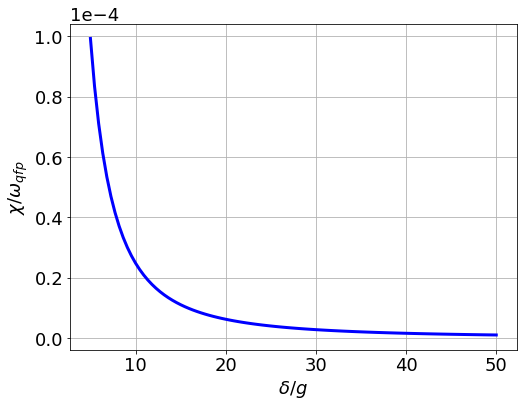

In [13]:
from pylab import rcParams
rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

ax.plot(rdg_list, chi_list, 'b', linewidth=3)

ax.set_xlabel(r'$\delta/g$')
ax.set_ylabel(r'$\chi/\omega_{qfp}$')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(True)
plt.savefig('2qo_chidelta.pdf')

In [14]:
rde2xx=10

In [15]:
chixx_list = []
for rdg in rdg_list:
    C = Hamilton(rde2xx, rdg, alpha)
    chixx_list.append(C[0]/omega_qfp2)

In [16]:
from pylab import rcParams
rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

ax.plot(rdg_list, chixx_list, 'b', linewidth=3)

ax.set_xlabel(r'$\delta/g$')
ax.set_ylabel(r'$\chi/\omega_{qfp}$')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(True)
plt.savefig('2qo_chideltaxx.pdf')

C:\Users\yanju\.conda\envs\qutip-env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
